<a href="https://colab.research.google.com/github/bailejor/SAMSHA_Transfer_Learning/blob/main/Heroin_transfer_opioid%20(Update%20March%202022).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer from heroin dataset to small non-heroin opioid set**

In this model transfer learning is implemented on a CNN model built from scratch. The model architecture from the CNN in experiment 1 are retained. This model was trained on a heroin use treatment dataset and then transfer learning occurs after replacing the sigmoid layer at the top of the model and allowing it to be trainable on half of the other opioid dataset. 

The opioid treatment dataset is small (1% of all non-heroin opioid treatment from 2018, n = ). It is meant to mimic clinical records that a treatment center in a large city or research lab would have access to. 

In [ ]:
pip install tf

In [1]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Activation, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, accuracy_score, roc_auc_score, fbeta_score, precision_recall_curve, precision_score, recall_score, f1_score, make_scorer, auc
from matplotlib import pyplot


In [ ]:
!unzip /content/drive/MyDrive/OpTrainImageshalf.nosync.zip

In [ ]:
!unzip /content/drive/MyDrive/OpTestImageshalf.nosync.zip

In [4]:
df = pd.read_csv('/content/drive/MyDrive/tedsd_puf_2018.csv', header  = 0)

In [5]:
df2 = pd.read_csv('/content/drive/MyDrive/tedsd_puf_2017.csv', header  = 0)

In [6]:
test_dataset = image_dataset_from_directory('/content/OpTestImageshalf.nosync', image_size=(250, 250), color_mode='rgb', shuffle=False, labels = 'inferred', label_mode = 'binary')

Found 1161 files belonging to 2 classes.


Found 1161 files belonging to 2 classes.
Using 929 files for training.
Found 1161 files belonging to 2 classes.
Using 232 files for validation.


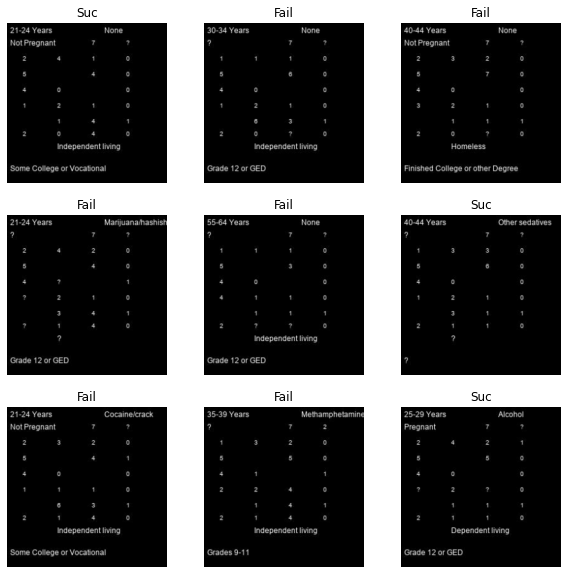

In [7]:
train_dataset_op = image_dataset_from_directory(
    '/content/OpTrainImageshalf.nosync',
    validation_split=0.2,
    subset="training",
    seed=6,
    image_size=(250, 250),
    batch_size=32,
    shuffle = True,
    color_mode = 'rgb'
)

validation_dataset_op = image_dataset_from_directory(
    '/content/OpTrainImageshalf.nosync',
    validation_split=0.2,
    subset="validation",
    seed=6,
    image_size=(250, 250),
    batch_size=32,
    shuffle = True,
    color_mode = 'rgb'
)



class_names = train_dataset_op.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset_op.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+ 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [8]:


model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(250, 250, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))





In [9]:


model_new = Sequential()
model.trainable = False
#Copy the trained model
for layer in model.layers[:-1]:
  model_new.add(layer)

model_new.load_weights('/content/drive/MyDrive/best_model_hero.h5')
#Add in new activation layer
model_new.add(Dense(1))
model_new.add(Activation('sigmoid'))
model_new.layers[-1].trainable = True
#model_new.layers[18].trainable = True

#For some reason this layer was set to trainable despite making the whole model untrainable

#model_new.trainable = True
#model_new.summary()
for layer in model_new.layers: print(layer, layer.trainable)          

callbacks = [EarlyStopping(monitor='val_loss', patience=3),
ModelCheckpoint(filepath='/content/drive/MyDrive/best_opi_model_smoll.h5', monitor='val_loss', save_best_only=True)]

#Recompile with all layers trainable and low learning rate
model_new.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer = tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()])



model_new.fit(train_dataset_op, epochs = 15, verbose = 1, validation_data = validation_dataset_op, callbacks = callbacks)

<keras.layers.convolutional.Conv2D object at 0x7fc0ccfece10> False
<keras.layers.core.activation.Activation object at 0x7fc0cc0589d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fc0cbeef150> False
<keras.layers.convolutional.Conv2D object at 0x7fc165ff9590> False
<keras.layers.core.activation.Activation object at 0x7fc0cbeefed0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fc0c036c210> False
<keras.layers.core.dropout.Dropout object at 0x7fc0c036c0d0> False
<keras.layers.convolutional.Conv2D object at 0x7fc0c036c590> False
<keras.layers.core.activation.Activation object at 0x7fc0c03617d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fc0c0305550> False
<keras.layers.convolutional.Conv2D object at 0x7fc0c030fcd0> False
<keras.layers.core.activation.Activation object at 0x7fc0c03057d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fc0c0349490> False
<keras.layers.core.dropout.Dropout object at 0x7fc0c02f28d0> False
<keras.layers.core.flatten.Flatten obj

In [13]:
pred[pred<0.5]=0
pred[pred>=0.5]=1

print(accuracy_score(test_labels, pred))
print(confusion_matrix(test_labels, pred))
print(precision_score(test_labels, pred))
print(recall_score(test_labels, pred))
print(fbeta_score(test_labels, pred, beta = 0.5))


0.7596899224806202
[[841  10]
 [269  41]]
0.803921568627451
0.13225806451612904
0.3988326848249027


Test Transfer Model Against Tuned Random Forest

In [11]:
model2 = Sequential()

model2.add(Conv2D(32, (3, 3), input_shape=(250, 250, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Dropout(0.25))

model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(256))
model2.add(Activation('relu'))

model2.add(Dropout(0.5))

model2.add(Dense(1))
model2.add(Activation('sigmoid'))

callbacks = [EarlyStopping(monitor='val_loss', patience=3),
ModelCheckpoint(filepath='/content/drive/MyDrive/best_opi_model_smoll_baseline.h5', monitor='val_loss', save_best_only=True)]

#Recompile with all layers trainable and low learning rate
model2.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer = tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()])



model2.fit(train_dataset_op, epochs = 15, verbose = 1, validation_data = validation_dataset_op, callbacks = callbacks)

Epoch 1/15
30/30 [==============================] - 6s 122ms/step - loss: 12.8334 - precision_1: 0.3231 - recall_1: 0.2500 - binary_accuracy: 0.6545 - true_positives_1: 63.0000 - true_negatives_1: 545.0000 - false_negatives_1: 189.0000 - false_positives_1: 132.0000 - val_loss: 0.6725 - val_precision_1: 0.5333 - val_recall_1: 0.1143 - val_binary_accuracy: 0.7026 - val_true_positives_1: 8.0000 - val_true_negatives_1: 155.0000 - val_false_negatives_1: 62.0000 - val_false_positives_1: 7.0000
Epoch 2/15
30/30 [==============================] - 2s 75ms/step - loss: 0.6286 - precision_1: 0.3016 - recall_1: 0.1508 - binary_accuracy: 0.6749 - true_positives_1: 38.0000 - true_negatives_1: 589.0000 - false_negatives_1: 214.0000 - false_positives_1: 88.0000 - val_loss: 0.6128 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_binary_accuracy: 0.6983 - val_true_positives_1: 0.0000e+00 - val_true_negatives_1: 162.0000 - val_false_negatives_1: 70.0000 - val_false_positives_1: 0.0000e+00
E

In [14]:



df = pd.concat([df2, df])
df = df.drop_duplicates(subset = ['CASEID'], keep = 'first')
df['REASON'].replace({2:0, 3:0, 4:0, 5:0, 6:0, 7:0}, inplace = True)
df = df[['CASEID', 'AGE', 'GENDER', 'RACE', 'ETHNIC', 'MARSTAT', 'EDUC', 'VET', 'PREG', 'EMPLOY', 'LIVARAG', 'ARRESTS',  'METHUSE', 'PSOURCE','NOPRIOR', 'SUB1', 'FREQ1', 'FRSTUSE1', 'SUB2', 'SUB3', 'ROUTE1', 'ROUTE2', 'ROUTE3', 'ALCFLG', 'COKEFLG', 'MARFLG', 'METHFLG', 'OPSYNFLG','HERFLG', 'SERVICES', 'SERVICES_D', 'REASON']]


methadone_use_false = [2]
methadone_use_true = [1]
sub_1_opiates = [7]
sub_1_heroin = [5]
sub_1_others = [1, 2, 3, 4, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


#Create second dataframe with just methadone treatment patients
df_opiates = df

#df_methadone = df_methadone.loc[df_methadone['METHUSE'].isin(methadone_use_true)]
#Return patients whose primary substance use is opiates
df_opiates = df_opiates.loc[df_opiates['SUB1'].isin(sub_1_opiates)]

#Get all patients who use opiates but NOT heroin
df_opiates = df_opiates.loc[~df_opiates['SUB2'].isin(sub_1_heroin)]
df_opiates = df_opiates.loc[~df_opiates['SUB3'].isin(sub_1_heroin)]


data_opiates = df_opiates.values

X_opiate = data_opiates[:,1:29]
y_opiate = data_opiates[:,31:32].ravel()

X_opiate_90, X_opiate_10, y_heroin_90, y_opiate_10 = train_test_split(X_opiate, y_opiate, test_size=0.01, random_state=33)
X_optrain_5, X_optest_5, y_optrain_5, y_optest_5 = train_test_split(X_opiate_10,  y_opiate_10, test_size=0.50, random_state=33)



param_grid = {'bootstrap':[True, False],
'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
'max_features': ['auto', 'sqrt'],
'min_samples_leaf':[1, 2, 4],
'min_samples_split':[2, 5, 10],
'n_estimators': [50, 200, 400, 600, 800, 1000],
'class_weight': [{0:50, 1:50}, {0:10, 1:90}, {0:20, 1:80}, {0:30, 1:70}, None]}

roc_auc = make_scorer(roc_auc_score)
balanced = make_scorer(balanced_accuracy_score)
acc = make_scorer(accuracy_score)
fbeta = make_scorer(fbeta_score, beta = 0.5)
rf = RandomForestClassifier(random_state= 33)

clf = RandomizedSearchCV(rf, param_grid, n_iter = 10, scoring = fbeta, n_jobs = 4, cv = 3, random_state = 33)
search = clf.fit(X_optrain_5, y_optrain_5)
print(search.best_params_)
print(search.best_score_)


rf2 = RandomForestClassifier(**search.best_params_)
rf2.fit(X_optrain_5, y_optrain_5)

yhat = rf2.predict(X_optest_5)

tn, fp, fn, tp = confusion_matrix(y_optest_5, yhat).ravel()

score1 = roc_auc_score(y_optest_5, yhat)
score2 = balanced_accuracy_score(y_optest_5, yhat)
score3 = accuracy_score(y_optest_5, yhat)
score4 = fbeta_score(y_optest_5, yhat, beta = 0.5)
pos_precision = precision_score(y_optest_5, yhat, pos_label = 1)
pos_recall = recall_score(y_optest_5, yhat, pos_label = 1)

neg_precision = precision_score(y_optest_5, yhat, pos_label = 0)
neg_recall = recall_score(y_optest_5, yhat, pos_label = 0)
print(tn, fp, fn, tp)


print(y_optest_5)
print(yhat)
print("The Accuracy Score is: " + str(score3))
print("The F0.5 Score is: " + str(score4))
print("The positive precision is: " + str(pos_precision))
print("The positive recall is: " + str(pos_recall))
print("The negative precision is: " + str(neg_precision))
print("The negative recall is: " + str(neg_recall))


rf_thresh = rf2.predict_proba(X_optest_5)[:, 1].flatten()

precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_optest_5, rf_thresh)
rf_auc_precision_recall = auc(recall_rf, precision_rf)
print(rf_auc_precision_recall)


{'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 90, 'class_weight': {0: 10, 1: 90}, 'bootstrap': True}
0.363109258801287
829 22 274 36
[0 1 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
The Accuracy Score is: 0.7450473729543498
The F0.5 Score is: 0.3321033210332104
The positive precision is: 0.6206896551724138
The positive recall is: 0.11612903225806452
The negative precision is: 0.7515865820489573
The negative recall is: 0.9741480611045829
0.43304159956486893


Compare precision-recall curve of random forest and CNN transfer model

0.49236344734862014
0.3433425678248846


Text(0, 0.5, 'Precision')

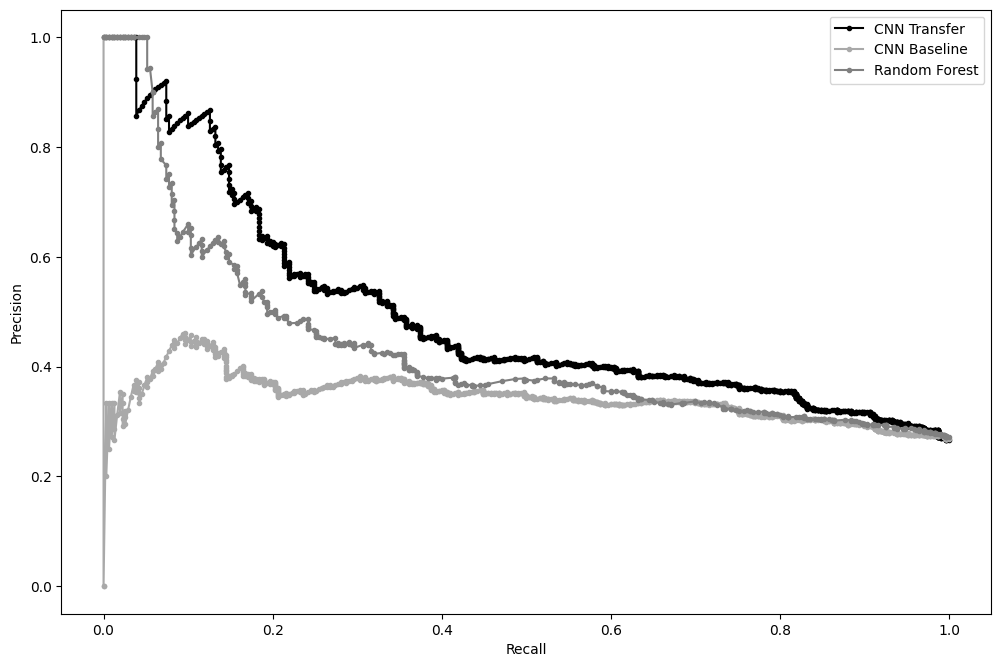

In [15]:
model_new.load_weights('/content/drive/MyDrive/best_opi_model_smoll.h5')

test_labels = []
test_classes = test_dataset.class_names
for images, labels in test_dataset:
  test_labels.append(labels)
test_labels = np.concatenate(test_labels, axis=0 )
test_labels = test_labels.flatten()


pred = model_new.predict(test_dataset)
pred = pred.flatten()

precision, recall, thresholds = precision_recall_curve(test_labels, pred)

nn_auc_precision_recall = auc(recall, precision)
print(nn_auc_precision_recall)


model2.load_weights('/content/drive/MyDrive/best_opi_model_smoll_baseline.h5')

test_labels2 = []
test_classes2 = test_dataset.class_names
for images, labels in test_dataset:
  test_labels2.append(labels)
test_labels2 = np.concatenate(test_labels2, axis=0 )
test_labels2 = test_labels2.flatten()


pred2 = model2.predict(test_dataset)
pred2 = pred2.flatten()

precision2, recall2, thresholds2 = precision_recall_curve(test_labels, pred2)

nn_auc_precision_recall = auc(recall2, precision2)
print(nn_auc_precision_recall)

pyplot.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
pyplot.plot(recall, precision, marker='.', label='CNN Transfer', color = 'k')
pyplot.plot(recall2, precision2, marker='.', label='CNN Baseline', color = 'darkgray')
pyplot.plot(recall_rf, precision_rf, marker='.', label='Random Forest', color = 'gray')
pyplot.legend()
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')





In [ ]:
pred2[pred2<0.5]=0
pred2[pred2>=0.5]=1

print(accuracy_score(test_labels, pred2))
print(confusion_matrix(test_labels, pred2))
print(precision_score(test_labels, pred2))
print(recall_score(test_labels, pred2))
print(fbeta_score(test_labels, pred2, beta = 0.5))

0.7329888027562446
[[851   0]
 [310   0]]
0.0
0.0
0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
